In [44]:
#imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, make_scorer, ConfusionMatrixDisplay, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RandomizedSearchCV
from sklearn.inspection import permutation_importance
pd.set_option('display.max_columns', None)
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [45]:
df = pd.read_csv('/Users/morganabbitt/galvanize/capstone/NFL-Analytics/data/NFL Play by Play 2009-2018 (v5).csv', low_memory=False)
#drop when the play is the last of the quarter
df = df[df['quarter_end'] == 0]
#grab all 4th downs
df_4 = df[df['down'] == 4.0]
#convert date to datetime
date = pd.to_datetime(df_4['game_date'].values)
#separate date and year
df_4['game_date'] = date
df_4['year'] = date.year
df_4 = df_4[df_4['play_type'] != 'no_play']
#to include no huddle or not include it? 
#Decided to keep no_huddle because only makes a difference of .003 accuracy score
df_4 = df_4[['yardline_100', 'half_seconds_remaining', 'posteam_type', 'drive', 'qtr', 
            'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'play_type',
             'score_differential', 'ep', 'posteam_score', 'defteam_score', 'no_huddle', 'year']]
#creates dummy columns for categorical variables and merges back to original along indicies
df_4 = pd.get_dummies(df_4['posteam_type']).merge(df_4.drop(columns='posteam_type'), left_index=True, right_index=True)
#0 is punt
df_4.loc[df_4['play_type'] == 'punt', 'target'] = 1
#1 is field goal
df_4.loc[df_4['play_type'] == 'field_goal', 'target'] = 0
#2 is go for it
df_4.loc[(df_4['play_type'] == 'run') | (df_4['play_type'] == 'pass') | (df_4['play_type'] == 'qb_kneel'), 'target'] = 2

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [46]:
#function that performs cross validation using KFolds 

def cross_val(estimator, X, y):
    '''
    estimator = The model you want to use with the sepcified paramters
                        ex: LogisticRegression(), RandomForestClassification() ...
                        
    data = clean dataframe you are working with, no nans
    
    clean_features = list of features you want to observe in your model
    
    target = target column you want to predict against
    '''

    kf = KFold(n_splits=5, shuffle=True)  # almost always use shuffle=True
    acc_scores = []
    f1_scores = []
    model = estimator   
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model.fit(X_train, y_train)
        y_test_pred = model.predict(X_test)
        #acc_scores.append(accuracy_score(y_test, y_test_pred))
        
        #change micro to weighted?
        #f1_scores.append(f1_score(y_test, y_test_pred, average='macro'))
        f1_scores.append(f1_score(y_test, y_test_pred, average='weighted'))
        #f1_scores.append(f1_score(y_test, y_test_pred, average='micro'))

    print('F1 Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(f1_scores)))
    #print('Accuracy Mean Score of {}: {:.3f}'.format(type(model).__name__, np.mean(acc_scores)))
    #print('Recall Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(recall_scores)))
    #print('Precision Mean Score of {} : {:.3f}'.format(type(model).__name__, np.mean(precision_scores)))
    return model 

In [47]:
#creates train and test set, train using 2013-2017 data and test using 2018 
#if working with RandomForests dont need to drop na, else dropna
#grabs year 2018 to test on 
test = df_4[df_4['year'] == 2018].dropna()
#grabs 5 pervious years for training
train = df_4[(df_4['year'] == 2017) | (df_4['year'] == 2016) | (df_4['year'] == 2015) | (df_4['year'] == 2014) | (df_4['year'] == 2013)].dropna()
#creates series for target 
y_test = test['target']
#drops target and playtype from X, playtype used to create target
X_test = test.drop(columns=['target', 'play_type']) 
#creates series for target
y_train = train['target']
#drops target and playtype columns
X_train = train.drop(columns=['target', 'play_type']) 

In [41]:
#base model: out of box multiclass logistic regression 
cross_val(LogisticRegression(solver='newton-cg', multi_class='multinomial'), X_train.values, y_train.values)

/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearc

F1 Mean Score of LogisticRegression: 0.877


/Users/morganabbitt/anaconda3/lib/python3.7/site-packages/sklearn/utils/optimize.py:212: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
#out of box random forest classifier
rf = cross_val(RandomForestClassifier(), X_train.values, y_train.values)

F1 Mean Score of RandomForestClassifier: 0.942


In [49]:
features = rf.feature_importances_.reshape(-1, 1)
fi = pd.DataFrame(data=features, index=X_train.columns)
fi.sort_values(by=0, inplace=True)
fi.index

lst = []
index = []
for arr in fi.values.reshape(1,-1):
    for x in arr:
        lst.append(x)
for ind in fi.index:
    index.append(ind)

In [44]:
#accuracy and f1 fall by .003 when not including the no_huddle feature 
#dont run, changed df_4 breifly to cross validate rf without the no_huddle column
#also uses f1 score 'micro' ---> now using f1 score 'weighted' to account for imbalanced classes
rf_nohuddle = cross_val(RandomForestClassifier(), X_train.values, y_train.values)

F1 Mean Score of RandomForestClassifier: 0.941
Accuracy Mean Score of RandomForestClassifier: 0.941


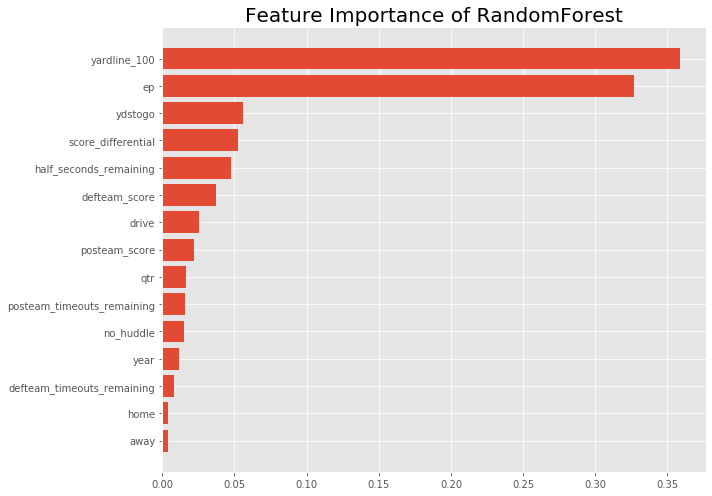

In [50]:
#feature importance of random forest out of box
plt.figure(figsize=(10,7))
plt.title('Feature Importance of RandomForest', size=20)
plt.yticks(size=10)
plt.barh(index, lst)
plt.tight_layout()

In [51]:
#creates confusion matrix by hand and normalizes by hand to check with plot_confusion_matrix
#creates array confusion matrix
cm = confusion_matrix(y_train, rf.predict(X_train.values))
#normalizes by hand
cm_normal = np.round(cm / cm.sum(axis=0), decimals=3)

<Figure size 1440x1440 with 0 Axes>

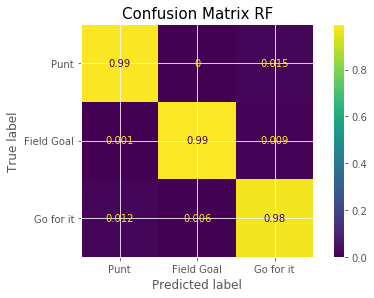

In [52]:
#plots the normalized confusion matrix using ConfusionMatrixDisplay
plt.figure(figsize=(20,20))
ConfusionMatrixDisplay(cm_normal, ['Punt', 'Field Goal', 'Go for it']).plot()
plt.tight_layout()
plt.title('Confusion Matrix RF', size=15);

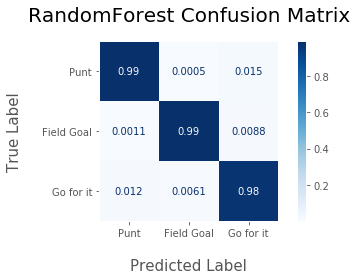

In [53]:
#train data confusion matrix using RandomForestClassifier
#adjusting the figsize throws off the size of the color bar, solution save as high resoultion and enlarge
fig, ax = plt.subplots(1) 
conf = plot_confusion_matrix(rf,X_train,y_train,normalize='pred',cmap='Blues',display_labels=np.array(['Punt','Field Goal', 'Go for it']), ax=ax)
conf.ax_.grid(False)
conf.ax_.set_title('RandomForest Confusion Matrix', size=20, pad=20)
#conf.ax_.set_figure(fig)
conf.ax_.set_xlabel('Predicted Label', size=15, labelpad=20)
conf.ax_.set_ylabel('True Label', size=15, labelpad=20)
plt.tight_layout()
plt.savefig('/Users/morganabbitt/galvanize/capstone/NFL-Analytics/graphics/rf_cm.png')

In [54]:
# parameter space for randomized grid search
#using random forest classifier
n_estimators = [50, 100, 200]
max_features = ['log2', 'sqrt', None]
max_depth = [2, 3, 6]
min_samples_split = [2, 4, 8]
min_samples_leaf = [1, 2, 4]
learning_rate  = [0.1, 0.05, 0.025]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
scorer = make_scorer(f1_score, average = 'weighted')
# create 20 gbc objects to be tuned and fitted
rf1 = RandomForestClassifier()
clf = RandomizedSearchCV(estimator = rf1, param_distributions = random_grid, n_iter = 10, scoring=scorer, n_jobs = -1, cv = 5, verbose=0)

In [55]:
#fitting the randomized search 
clf.fit(X_train.values, y_train.values)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [56]:
#retrieving the best parameters that the grid search found
clf.best_params_

{'n_estimators': 50,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': 6}

In [57]:
#pass best parameters into random forest classifier
cross_val(RandomForestClassifier(n_estimators=50, min_samples_leaf=4, min_samples_split=8, max_features=None, max_depth=6), X_train.values, y_train.values)

F1 Mean Score of RandomForestClassifier: 0.924


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=None,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=8,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [59]:
#out of box gradient boosting classifier 
cross_val(GradientBoostingClassifier(), X_train.values, y_train.values)

F1 Mean Score of GradientBoostingClassifier: 0.943


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [61]:
#parameters for randomized grid search
#using gradient boosting classifier
n_estimators = [50, 100, 200]
max_features = ['log2', 'sqrt', None]
max_depth = [2, 3, 6]
min_samples_split = [2, 4, 8]
min_samples_leaf = [1, 2, 4]
learning_rate  = [0.1, 0.05, 0.025, 0.001]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
scorer = make_scorer(f1_score, average = 'weighted')
# create 20 gbc objects to be tuned and fitted
gbc = GradientBoostingClassifier()
clf2 = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid, n_iter = 10, scoring=scorer, n_jobs = -1, cv = 5, verbose=0)

In [62]:
#fit the randomized search 
clf2.fit(X_train.values, y_train.values)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                        criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                    

In [63]:
#retrieve the best parameters
clf2.best_params_

{'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 6}

In [64]:
#run gradient boosting classifier using the best parameters from the randomized search
gbc = cross_val(GradientBoostingClassifier(n_estimators=100, min_samples_split=8, min_samples_leaf=1, max_features=None, max_depth=6), X_train.values, y_train.values)

F1 Mean Score of GradientBoostingClassifier: 0.954


In [66]:
#fit on the test data
gbc.fit(X_train.values, y_train.values)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=6,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=8,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [67]:
#grab importance features for feature importance from test data
gbc.feature_importances_

array([1.30848580e-04, 1.32698872e-04, 6.55234732e-01, 4.32347608e-02,
       7.08061919e-03, 2.09817318e-02, 6.29199261e-02, 7.44029387e-03,
       8.79393039e-04, 4.98239565e-02, 9.00237324e-02, 3.30319046e-03,
       3.73429790e-02, 2.02261519e-02, 1.24498573e-03])

In [68]:
#reshape the features
features = gbc.feature_importances_.reshape(-1, 1)
#create dataframe grouping each feat importance with the corresponding feature (column)
f_im = pd.DataFrame(data=features, index=X_train.columns)
#sort by 0th column inplace for plotting purposes
f_im.sort_values(by=0, inplace=True)

#this loop creates an index and the list of importances
lst2 = []
index2 = []
for arr in f_im.values.reshape(1,-1):
    for x in arr:
        lst2.append(x)
for ind in f_im.index:
    index2.append(ind)

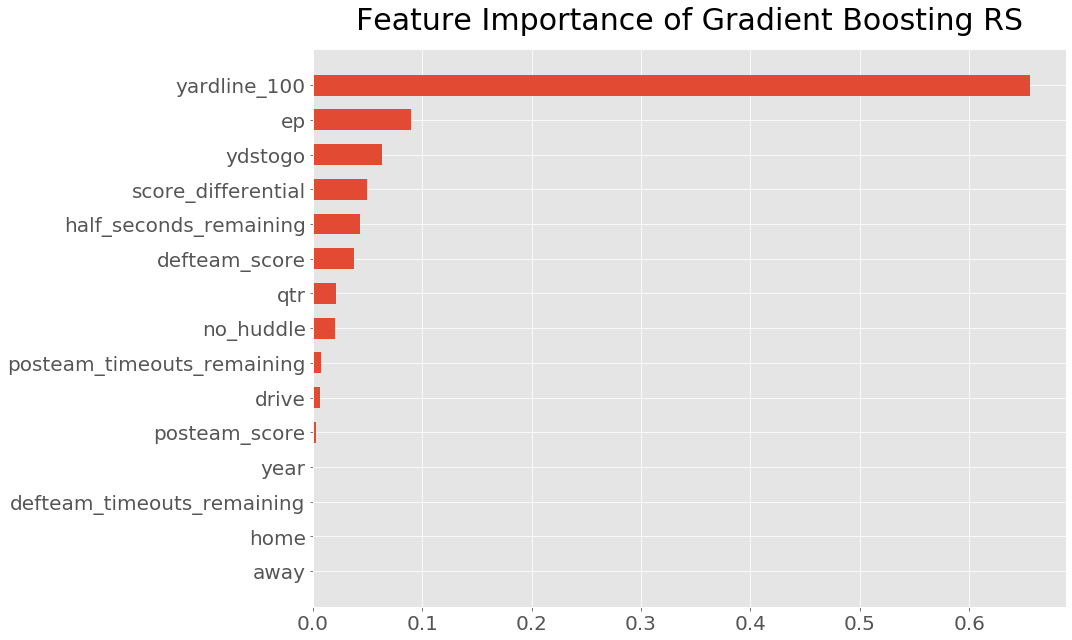

In [69]:
#plots the feature importance 
plt.figure(figsize=(15,9))
plt.title('Feature Importance of Gradient Boosting RS', size=30,pad=20)
plt.yticks(size=20)
plt.xticks(size=20)
plt.barh(index2, lst2, height=0.6)
plt.tight_layout()
plt.savefig('/Users/morganabbitt/galvanize/capstone/NFL-Analytics/graphics/feat_importance_gbc.png', dpi=100, bbox_inches='tight')

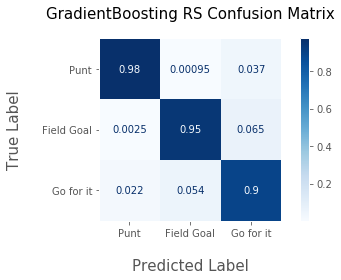

In [77]:
#Confusion matrix on test data for final model
#final test, dont run 
fig, ax = plt.subplots(1)
conf = plot_confusion_matrix(gbc, X_test, y_test, normalize='pred', cmap='Blues', display_labels=np.array(['Punt','Field Goal', 'Go for it']), ax=ax)
conf.ax_.grid(False)
conf.ax_.set_title('GradientBoosting RS Confusion Matrix', size=15, pad=20)
#conf.ax_.set_figure(fig)
conf.ax_.set_xlabel('Predicted Label', size=15, labelpad=20)
conf.ax_.set_ylabel('True Label', size=15, labelpad=20)
plt.tight_layout()
plt.savefig('/Users/morganabbitt/galvanize/capstone/NFL-Analytics/graphics/gbc_cm.png', dpi=300)

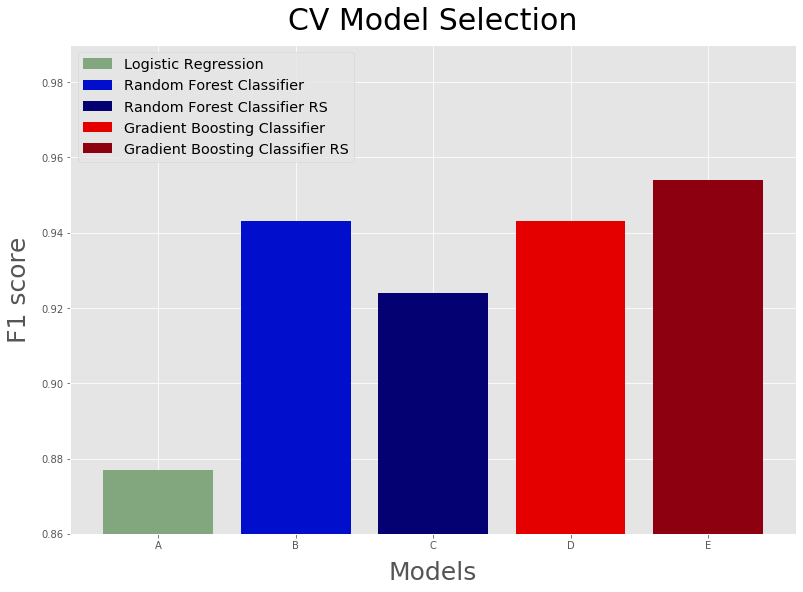

In [70]:
#plotting cv f1 scores of each model to determine model selection 
ypos = ['A', 'B', 'C', 'D', 'E']
colors = ['lightblue', 'lavender', 'navy', 'coral', 'plum']
plt.figure(figsize=(13,9))
plt.title('CV Model Selection', size=30, pad=15)
plt.bar('A', 0.877, color='xkcd:greyish green', label='Logistic Regression')
plt.bar('B', 0.943, color='xkcd:true blue', label='Random Forest Classifier')
plt.bar('C', 0.924, color='xkcd:deep blue', label='Random Forest Classifier RS')
plt.bar('D', 0.943, color='xkcd:red', label='Gradient Boosting Classifier')
plt.bar('E', 0.954, color='xkcd:crimson', label='Gradient Boosting Classifier RS')
plt.ylim(0.86, .99)
plt.xlabel('Models', size=25, labelpad=10)
plt.ylabel('F1 score', size=25, labelpad=10)
plt.legend(fontsize='x-large', loc='upper left')
plt.savefig('/Users/morganabbitt/galvanize/capstone/NFL-Analytics/graphics/model_selection.png', dpi=200)

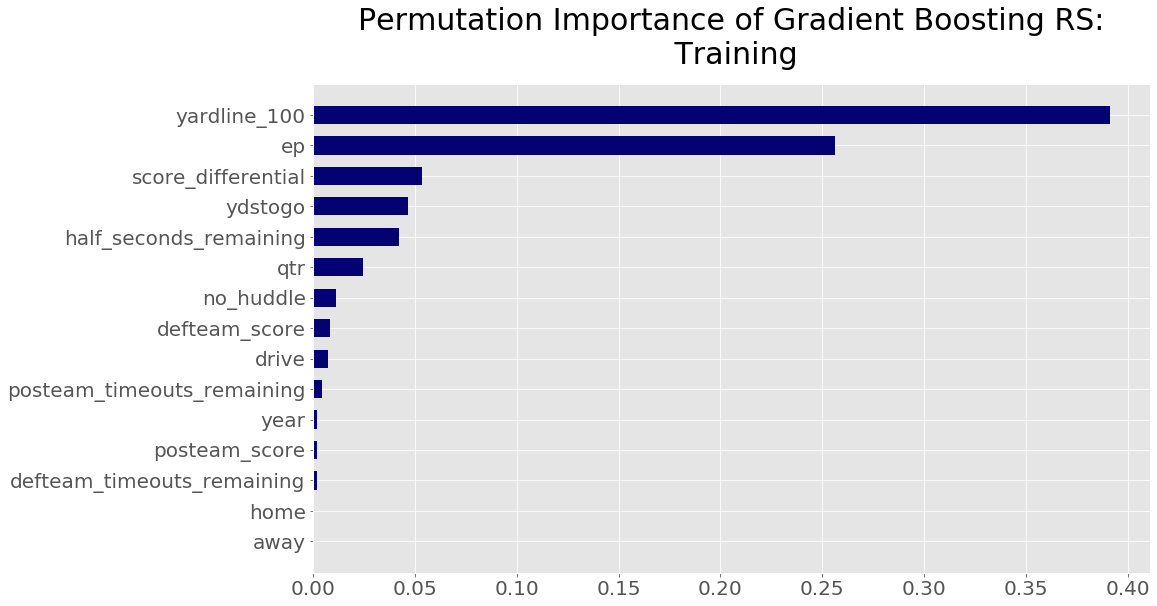

In [78]:
#calculating permutation importances for gbc on the training set 
#scorer was defined in the randomized search which uses f1 and average='weighted'
result_train = permutation_importance(gbc, X_train.values, y_train.values, scoring=scorer)
#sorts the importances_mean and returns indicies
sorted_idx = result_train.importances_mean.argsort()

#plots permutation importance for gbc training set 
plt.figure(figsize=(15,9))
plt.barh(width=result_train.importances_mean[sorted_idx], y=X_train.columns[sorted_idx], height=0.6, color='xkcd:deep blue')
plt.yticks(size=20)

plt.xticks(size=20)
plt.title('Permutation Importance of Gradient Boosting RS:\n Training', size=30, pad=20)
plt.savefig('/Users/morganabbitt/galvanize/capstone/NFL-Analytics/graphics/perm_imptnt_train.png', dpi=100, bbox_inches='tight')



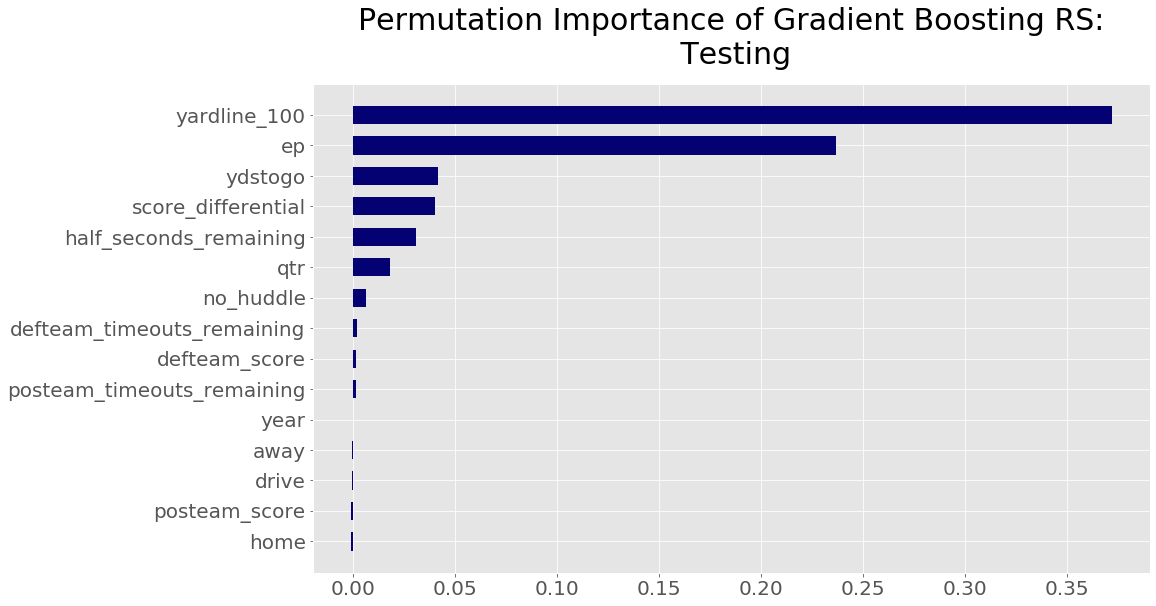

In [79]:
#calculating permutation importances for gbc on the testing set 
#scorer was defined in the randomized search which uses f1 and average='weighted'
result_test = permutation_importance(gbc, X_test.values, y_test.values, scoring=scorer)
#sorts the importances_mean and returns indicies
sorted_idx2 = result_test.importances_mean.argsort()

#plots permutation importance for gbc testing set 
plt.figure(figsize=(15,9))
plt.barh(width=result_test.importances_mean[sorted_idx2], y=X_test.columns[sorted_idx2], height=0.6, color='xkcd:deep blue')
plt.yticks(size=20)

plt.xticks(size=20)
plt.title('Permutation Importance of Gradient Boosting RS:\n Testing', size=30, pad=20)
plt.savefig('/Users/morganabbitt/galvanize/capstone/NFL-Analytics/graphics/perm_imptnt_test.png', dpi=100, bbox_inches='tight')



In [80]:
#Final Score of gbc rs
y_pred = gbc.predict(X_test.values)
score = f1_score(y_test.values, y_pred, average='weighted')

In [81]:
score

0.9447148505831838